<a id = "cell_Preprocessing"></a>
## 1. Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from google.colab import files
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

### **Load the Dataset**

In [3]:
uploaded = files.upload() # Data souce - Kaggle
filename = next(iter(uploaded))

date_format = "%d/%m/%Y"
df = pd.read_csv(filename, index_col='Date', parse_dates=["Date"], date_parser=lambda x: pd.to_datetime(x, format=date_format))
df

Saving Part3_Weather.csv to Part3_Weather (4).csv


,meantemp,humidity,wind_speed,meanpressure
Date,,,,
2013-01-01,10.000000,84.500000,0.000000,10.156667
2013-01-02,7.400000,92.000000,2.980000,10.178000
2013-01-03,7.166667,87.000000,4.633333,10.186667
2013-01-04,8.666667,71.333333,1.233333,10.171667
2013-01-05,6.000000,86.833333,3.700000,10.165000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,9.986250
2017-04-21,34.250000,39.375000,6.962500,9.998750
2017-04-22,32.900000,40.900000,8.890000,10.016000


### **Data Preprocessing**

#### Re-arrange the column names

In [4]:
df = df[['humidity', 'meantemp', 'wind_speed', 'meanpressure']]
df

,humidity,meantemp,wind_speed,meanpressure
Date,,,,
2013-01-01,84.500000,10.000000,0.000000,10.156667
2013-01-02,92.000000,7.400000,2.980000,10.178000
2013-01-03,87.000000,7.166667,4.633333,10.186667
2013-01-04,71.333333,8.666667,1.233333,10.171667
2013-01-05,86.833333,6.000000,3.700000,10.165000
...,...,...,...,...
2017-04-20,27.500000,34.500000,5.562500,9.986250
2017-04-21,39.375000,34.250000,6.962500,9.998750
2017-04-22,40.900000,32.900000,8.890000,10.016000


#### **Missing value Investigation**

In [5]:
df.isna().sum()

humidity        0
meantemp        0
wind_speed      0
meanpressure    0
dtype: int64

* No missing values in the dataset

In [6]:
df.dtypes

humidity        float64
meantemp        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [7]:
df.shape

(1575, 4)

In [8]:
summary = df.describe()
print(summary)

          humidity     meantemp   wind_speed  meanpressure
count  1575.000000  1575.000000  1575.000000   1575.000000
mean     60.420115    25.231582     6.903642     10.105897
std      16.956083     7.337316     4.508803      1.752983
min      13.428571     6.000000     0.000000     -0.030417
25%      49.750000    18.516667     3.700000     10.018750
50%      62.380952    27.166667     6.370000     10.090000
75%      72.125000    31.142857     9.262500     10.151833
max      98.000000    38.714286    42.220000     76.793333


Above table presents statistical summaries for four different numerical features: humidity, meantemp, wind_speed, and meanpressure. These statistics are computed based on a dataset containing 1575 observations. The summary includes various descriptive measures for each feature:

- **humidity**: The average humidity is approximately 60.42, with a standard deviation of around 16.96. Humidity ranges from a minimum of 13.43 to a maximum of 98.

- **meantemp**: The average mean temperature is about 25.23, with a standard deviation of approximately 7.34. The temperature varies between a minimum of 6 and a maximum of 38.71.

- **wind_speed**: The average wind speed is roughly 6.90, with a standard deviation of about 4.51. Wind speed values range from a minimum of 0 to a maximum of 42.22.

- **meanpressure**: The average mean atmospheric pressure is approximately 10.11, with a standard deviation of around 1.75. Mean pressure varies from a minimum of -0.03 to a maximum of 76.79.

Additionally, the table provides quartile information (25th, 50th, and 75th percentiles), which gives insight into the distribution and spread of each feature's values within the dataset.

### **Visulization**

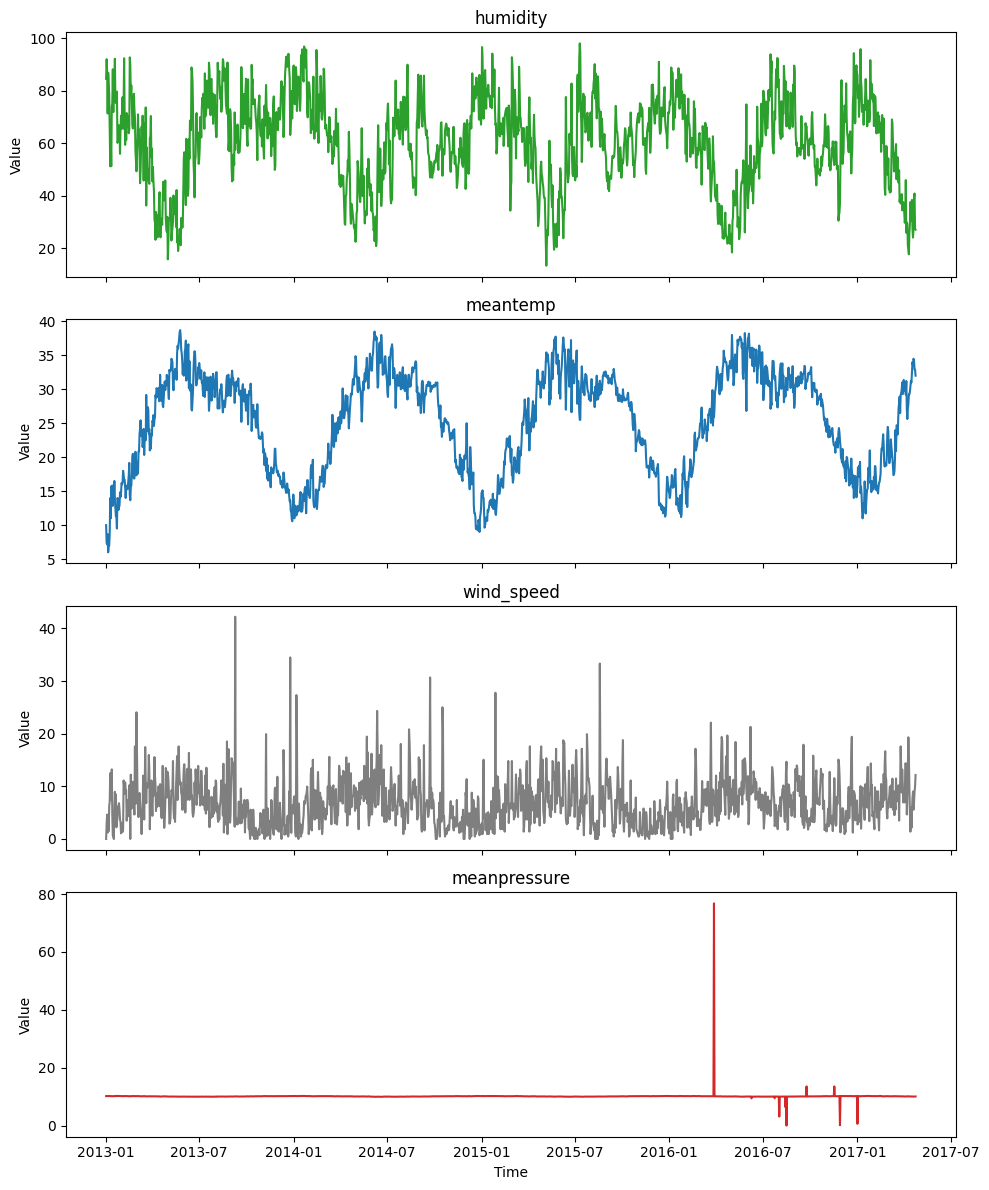

In [9]:
colors = ['tab:green', 'tab:blue', 'tab:grey', 'tab:red']
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
for i, (column, color) in enumerate(zip(['humidity', 'meantemp', 'wind_speed', 'meanpressure'], colors)):
    sns.lineplot(data=df[column], ax=axs[i], color=color)
    axs[i].set_title(column)
    axs[i].set_ylabel('Value')
axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

* I can observe outliers in the "meanpressure" values. 
* The variables "humidity," "meantemp," and "wind_speed" exhibit seasonal fluctuations.

### **Training and Test Sets**

Input "tstart" and "tend" set training and testing year ranges. The function extracts rows from "dataset" within these ranges to create "training_set." "test_set" contains data post-"tend." 

In [10]:
tstart = 2013
tend = 2016

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"]
    test = dataset.loc[f"{tend+1}":]
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

### **Min-Max Scalling**

Apply the `MinMaxScaler` function to normalize the training set, enhancing resilience against outliers or anomalies.

In [11]:
training_set_shape = training_set.shape
test_set_shape = test_set.shape
print('training_set shape:', training_set_shape)
print('test_set shape:', test_set_shape)

training_set shape: (1461, 4)
test_set shape: (114, 4)


In [12]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape after scaling:', training_set_scaled.shape)

training_set_scaled shape after scaling: (5844, 1)


In [13]:
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])
print('training_set_scaled shape:', training_set_scaled.shape)

training_set_scaled shape: (1461, 4)


Before scalling:

In [14]:
training_set

array([[84.5       ],
       [10.        ],
       [ 0.        ],
       ...,
       [15.05263158],
       [ 7.325     ],
       [10.161     ]])

After scalling:

In [15]:
training_set_scaled

array([[8.62287640e-01, 1.02319433e-01, 3.10277851e-04, 1.03917577e-01],
       [9.38794507e-01, 7.57970528e-02, 3.07090061e-02, 1.04135196e-01],
       [8.87789929e-01, 7.34168392e-02, 4.75745198e-02, 1.04223604e-01],
       ...,
       [8.96533571e-01, 1.55752800e-01, 6.15157710e-02, 1.04043874e-01],
       [9.14992371e-01, 1.44094611e-01, 6.42360152e-02, 1.04145883e-01],
       [8.87789929e-01, 1.53860901e-01, 7.50319841e-02, 1.03961781e-01]])

<a id = "cell_model"></a>
## 2. Predictive Modeling

In here, we employ parameters `n_steps=50` and `forecasting_horizon=14 (2 weeks)` to construct a predictive model. The objective is to forecast the mean daily temperature `meantemp` for a forteen-day horizon using input features 'humidity', 'meantemp', 'wind_speed', and 'meanpressure'.

In [16]:
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [17]:
n_steps = 50
forecasting_horizon = 14
features = 4
y_index = 1

# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon,y_index)

In [18]:
# Reshaping X_train for model
y_train  = y_train.reshape(y_train .shape[0],y_train.shape[1],1)

In [19]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (1398, 50, 4)
y_train shape: (1398, 14, 1)


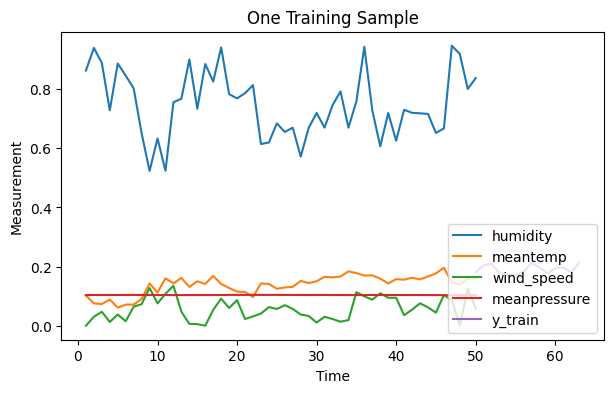

In [20]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,0])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,1])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,2])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,3])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['humidity', 'meantemp' ,'wind_speed', 'meanpressure', 'y_train'], loc='lower right')

#### **The LSTM architecture** 

In [21]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=14))
model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 14)                1414      
                                                                 
Total params: 43,414
Trainable params: 43,414
Non-trainable params: 0
_________________________________________________________________


- The model creation follows a sequential approach facilitated by the Keras library.
- It begins with the instantiation of a `Sequential` model, serving as a linear stack for subsequent layers.
- An LSTM layer is added, with the following characteristics:
  - It consists of a user-defined number of units, which act as specialized memory cells.
  - The hyperbolic tangent activation function is applied to these memory cells, enabling the detection of sequential patterns.
  - The input shape parameter accounts for the temporal dimension of the data and the attributes associated with each time step.
- A densely connected layer is subsequently included:
  - The number of neurons in this layer is determined by the provided `units` parameter.
  - This layer contributes to the further refinement of processed information.
- During compilation, the model is configured with:
  - The "RMSprop" optimization algorithm to facilitate efficient training.
  - The mean squared error (MSE) loss function, suitable for regression tasks, to quantify the disparity between predicted and actual values.

#### Fit the LSTM model

In [22]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 4s 41ms/step - loss: 0.0086
Epoch 2/100
44/44 [==============================] - 2s 39ms/step - loss: 0.0026
Epoch 3/100
44/44 [==============================] - 2s 40ms/step - loss: 0.0019
Epoch 4/100
44/44 [==============================] - 2s 53ms/step - loss: 0.0017
Epoch 5/100
44/44 [==============================] - 3s 65ms/step - loss: 0.0014
Epoch 6/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0013
Epoch 7/100
44/44 [==============================] - 2s 40ms/step - loss: 0.0012
Epoch 8/100
44/44 [==============================] - 2s 40ms/step - loss: 0.0012
Epoch 9/100
44/44 [==============================] - 2s 54ms/step - loss: 0.0011
Epoch 10/100
44/44 [==============================] - 3s 68ms/step - loss: 0.0011
Epoch 11/100
44/44 [==============================] - 3s 68ms/step - loss: 0.0010
Epoch 12/100
44/44 [==============================] - 3s 60ms/step - loss: 0.0010
Epoch 13/100
44/44 [=====

We will initiate a repetition of preprocessing by normalizing the test set. Initially, the dataset will undergo transformation and segmentation into individual samples, followed by reshaping. Subsequently, predictions will be generated, and these predictions will be reverted back to their standard form through an inverse transformation process.

In [23]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)

#Reshape back to orignal format after rescaling
inputs = inputs.reshape(test_set_shape[0], test_set_shape[1])

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon,y_index)
number_test_samples = X_test.shape[0]
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (51, 50, 4)
y_test shape: (51, 14)


In [24]:
#prediction
predicted_mean_temp = model_lstm.predict(X_test)

#inverse transform the predicted values
predicted_mean_temp = sc.inverse_transform(predicted_mean_temp)
print('predicted_mean_temp shape: ', predicted_mean_temp.shape)

2/2 [==============================] - 1s 18ms/step
predicted_mean_temp shape:  (51, 14)


Next, we assess the prediction performance by comparing actual and predicted values. Notably, as the forecasting horizon extends into the future, the predictive performance tends to diminish.

In [25]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_mean_temp[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 24.35.

Forecasting Horizon: 1 
Mean Absolute Error 24.07.

Forecasting Horizon: 2 
Mean Absolute Error 23.99.

Forecasting Horizon: 3 
Mean Absolute Error 24.18.

Forecasting Horizon: 4 
Mean Absolute Error 24.60.

Forecasting Horizon: 5 
Mean Absolute Error 25.25.

Forecasting Horizon: 6 
Mean Absolute Error 25.14.

Forecasting Horizon: 7 
Mean Absolute Error 25.94.

Forecasting Horizon: 8 
Mean Absolute Error 26.01.

Forecasting Horizon: 9 
Mean Absolute Error 25.86.

Forecasting Horizon: 10 
Mean Absolute Error 25.96.

Forecasting Horizon: 11 
Mean Absolute Error 26.00.

Forecasting Horizon: 12 
Mean Absolute Error 26.75.

Forecasting Horizon: 13 
Mean Absolute Error 26.84.



Inverse transform the test data to orignal unit for visualization

In [26]:
y_test = sc.inverse_transform(y_test)

X_test = X_test.reshape(-1, 50)
X_test = sc.inverse_transform(X_test)
X_test = X_test.reshape(number_test_samples, 50, 4)

Illustrate the comparison between observed testing values and their corresponding predicted values for each distinct segment of the testing time series.

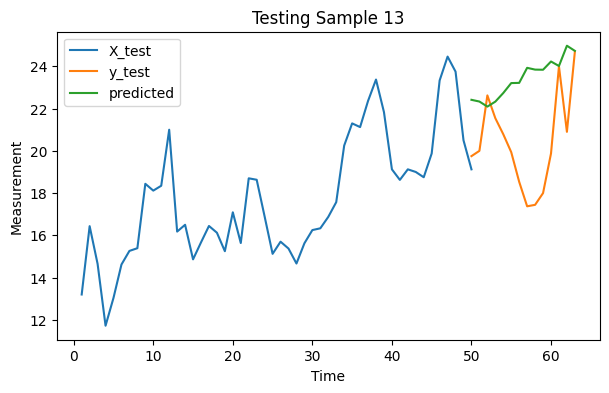

In [27]:
#Here we visualize the real vs. predicted values of the last testing segment.
sample_index = 13

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,1])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_mean_temp[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

Plot the actual testing values against the corresponding predicted values for each forecasting horizon.

In [28]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Mean daily temperature Prediction")
    plt.xlabel("Days Ahead")
    plt.ylabel("Mean daily temperature")
    plt.legend()
    plt.show()

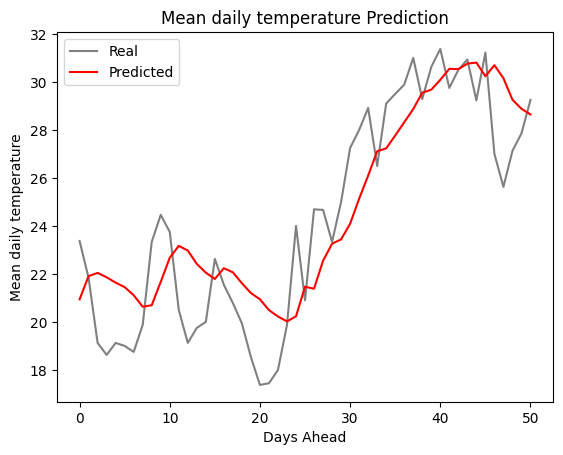

In [29]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],predicted_mean_temp[:,0])

<a id = "cell_report"></a>
## 3. Report

#### How to improve the performance of the above devoloped multi-variate forecasting model

**Model Architecture:**

**Activation and Optimizer:**

- **Activation Function:** Try different activation functions like ReLU for the LSTM units. Different activation functions can influence the learning behavior of the model.
- **Optimizer Selection:** Experiment with different optimizers, not just RMSprop. Adam and SGD are also commonly used optimizers for sequence models. Each optimizer has its strengths in different scenarios.

**Model Complexity:**

- **Model Size:** If your dataset is small, consider reducing the number of LSTM units or using simpler architectures to prevent overfitting.

**Regularization:**

- **Dropout:** Add dropout layers between LSTM layers. Dropout can prevent overfitting by randomly dropping a certain portion of connections during training.
- **L2 Regularization:** Apply L2 regularization to the LSTM layers. This can help prevent the model from focusing too much on a single feature and encourage more balanced learning.

**Learning Rate:**

- **Learning Rate Schedule:** Implement a learning rate scheduler to adjust the learning rate during training. This can help the model find an optimal learning rate for faster convergence.

**Sequence Length:**

- **Adjust Sequence Length:** Try different sequence lengths (n_steps). Longer sequences can capture longer-term patterns, but they might also introduce more complexity.

**Feature Engineering:**

- **Feature Selection:** Analyze which features are contributing the most to the forecasting. You can consider removing less relevant features to simplify the model.

**Hyperparameter Tuning:**

- **Grid Search:** Perform a grid search to find optimal hyperparameters like the number of LSTM units, learning rate, and batch size. This can help fine-tune the model's performance.

**Validation Strategy:**

- **Cross-Validation:** Implement cross-validation to assess the model's performance across different subsets of data. This provides a more reliable estimate of the model's generalization ability.

